### Summary:
Successfully modified the VGG16 network architecture to support Class Activation Maps (CAM).
Using a pre-trained VGG16, we remove the classifier module layers as well as the final maxpool layer of the features module; this leaves us with the final convolution layer to which we connect a Global Average Pool layer followed by a softmax classification layer. We then freeze all the model parameters except for this final softmax layer and train the model so that, for a given class, it learns the appropriate weightings to each final feature map.

As discussed in last weeks meeting, we use the register_forward_hook method to extract the final feature map activations from our model and store it as feature_blobs.
Next, within the ReturnCam function, we take the dot products of the featuremaps and the GAP trained featuremap weighting parameters from the softmax layer to obtain a resultant linear combination that is the CAM for that class.

Finally we upsample the CAM and overlay it on the original image and save to disk.

### Notes: 
My machine's gpu is no longer supported by pytorch, so I trained with cpu on a small two class test dataset for two epochs for this proof of concept experiment. dataset and some borrowed wrangling code is available here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

In [86]:
#Summary of CAM-modified VGG16 model
model_conv

Net2(
  (model1_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

In [1]:
#imports, streamline unnecessary imports later
%matplotlib inline
import os
import random
from collections import OrderedDict, namedtuple
from tqdm import tqdm
import pandas as pd
import scipy.io as spio
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset 
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import cv2
import cnn_finetune

Standard Image Pre-Processing

In [2]:
# Data augmentation and normalization for training
# Normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#force to cpu since my gpu make is no longer supported by pytorch, otherwise use: 
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
#create dictionary for label/index and corresponding class
#in this case there are only two: 0 : ant and 1 : bee

#this approach causes classes to become a tensor, but dict is needed
#classes = {label : name for label, name in enumerate(class_names)}

#since there are only two name value pairs, our dict can just be:
classes = {0: class_names[0], 1: class_names[1]}

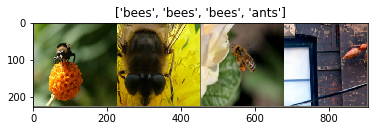

In [4]:
#visualize a batch of images from training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


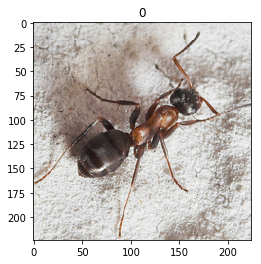

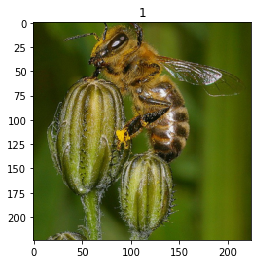

In [5]:
#Visualize some images from the val set
dset = image_datasets['val']
#print(len(dset))
imshow(dset[15][0], title = dset[15][1])

imshow(dset[89][0], title = dset[89][1])

Load Pre-trained VGG16 and modify architecture for CAM

In [6]:
#Load pre-trained vgg16
basemodel = models.vgg16(pretrained=True)

In [7]:
# Create modified version of VGG16
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # all CNN model layers
        layers = list(basemodel.features.children())[:-1] #get allfeatures module layers and remove last maxpooling layer
        layers.append(nn.AvgPool2d(14, stride = 1))  #global average pooling layer
        #layers.append(nn.Linear(in_features = 512, out_features = 2, bias = True)) #Define Fully connected layer? Not Needed
        # plug-in the layers into our model
        self.model1_layers = nn.Sequential(*layers)
                
    def forward(self, x):
        x = F.relu(self.model1_layers[0](x))
        x = F.max_pool2d(F.relu(self.model1_layers[2](self.model1_layers[1](x))), 2)
        x = F.max_pool2d(F.relu(self.model1_layers[7](F.relu(self.model1_layers[5](x)))),2)
        x = F.relu(self.model1_layers[12](F.relu(self.model1_layers[10](x))))
        x = F.max_pool2d(F.relu(self.model1_layers[14](x)),2)
        x = F.relu(self.model1_layers[19](F.relu(self.model1_layers[17](x))))
        x = F.max_pool2d(F.relu(self.model1_layers[21](x)),2)
        x = F.relu(self.model1_layers[24](x))
        x = F.relu(self.model1_layers[26](x))
        x = F.relu(self.model1_layers[28](x))
        x = self.model1_layers[30](x) #global avg pool layer
        x = x.view(-1, 512)
        x = model_conv.fc(x) # add the fully connected layer in the forward pass
        return x
    
mod_vgg = Net2()

In [8]:
#Freeze all layers defined in mod_vgg
model_conv = mod_vgg
for param in model_conv.parameters():
        param.requires_grad = False
    
#Add fully connected layer as final layer to mod_vgg and assign as model_conv.fc          
#Parameters of newly constructed modules have requires_grad=True by default    
num_ftrs = 512
model_conv.fc = nn.Linear(num_ftrs, 2)

In [9]:
# test dimensions on a constant tensor
x = Variable(torch.ones(1,3,224,224))
# using the .data attribute to get the tensor out of the variable
out = torch.squeeze(mod_vgg.forward(x).data)
print(out.size())
print(out.type())

#turn to cpu before converting to numpy
numpy_out = out.cpu().numpy()
numpy_out.shape

torch.Size([2])
torch.FloatTensor


(2,)

In [10]:
#check model forward pass output dimensions again
x = Variable(torch.ones(1,3,224,224))
out = mod_vgg.forward(x)
out.shape

torch.Size([1, 2])

In [11]:
#Make sure that the Fully Connected layer is the only trainable layer
for name, param in model_conv.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.data)

fc.weight torch.Size([2, 512]) tensor(1.00000e-02 *
       [[-1.4486, -1.3065,  1.4048,  ..., -1.6497, -1.7946,  2.9573],
        [-0.8919, -4.3157,  0.7954,  ...,  1.6662, -3.3270, -0.0370]])
fc.bias torch.Size([2]) tensor(1.00000e-02 *
       [ 1.0680,  1.4940])


Train Modified VGG16 Model

In [12]:
#Setup Loss and Scheduler for training

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
#Borrowed training function from tranfer learning tutorial
#available here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
#train final layer of model for 2 epochs because cpu is slow
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5236 Acc: 0.7828
val Loss: 0.3309 Acc: 0.9477

Epoch 1/1
----------
train Loss: 0.3269 Acc: 0.9385
val Loss: 0.2592 Acc: 0.9542

Training complete in 11m 60s
Best val Acc: 0.954248


Get FC weights & Final Feature Maps & Visualize CAMS:

In [37]:
#set model to evaluation mode
model_conv.eval()

Net2(
  (model1_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

In [46]:
#Take an image and run it through the CAMVGG16 model:
dset = image_datasets['val']
test_image = Variable(dset[89][0].unsqueeze(0))


In [73]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


In [74]:
#hook the feature extractor
model_conv._modules.get('model1_layers')[29].register_forward_hook(hook_feature).

#n.b. remember to reinitialize features_blobs array and to remove() and reattach hook
#each time we want to reextract a new feature volume for features_blobs[0]


In [75]:
#do one forward pass of image through model
logit = model_conv(test_image)
h_x = F.softmax(logit).data.squeeze()
probs, idx = h_x.sort(0, True)

C:\Users\IBM_ADMIN\Anaconda3\envs\zenas1\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
features_blobs[0].shape

(1, 512, 14, 14)

In [78]:
#reassert as dictionary
classes = {0: class_names[0], 1: class_names[1]}

In [79]:
weight_softmax.shape

(2, 512)

In [80]:
params = list(model_conv.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

#return cam function by metalbubble
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [82]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])


In [83]:
for i in range(0,2):
    print('{:,.3f}->{}'.format(probs[i], classes.get(idx.data.cpu().numpy()[i])))


0.865->bees
0.135->ants


In [84]:
#open the ant image dset[x][0]
#save it as test1

img_pil = Image.open(image_datasets['val'].imgs[89][0])
img_pil.save('test1.jpg')


In [85]:
print('output CAM.jpg for the top1 prediction: %s'%classes.get(idx.data.cpu().numpy()[0]))
img = cv2.imread('test1.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM1.jpg', result)


output CAM.jpg for the top1 prediction: bees


True